# Modelo predictivo para recomendación de planes en Megaline

## Contenido

* [Introducción](#intro)  
* [1. Descripción y preparación de los datos](#data_review)
* [2. Análisis exploratorio de los datos](#data_analysis)
* [3. Segmentación de los datos para el entrenamiento del modelo](#data_segment)
* [4. Exploración para elegir el modelo](#model_explore)
    * [4.1. Exploración del modelo Decision Tree Classifier](#model_decision_tree)
    * [4.2. Exploración del modelo Random Forest Classifier](#model_random_forest)
    * [4.3. Exploración del modelo Logistic Regression](#model_logistic_regression)
    * [4.4. Resultados y selección del modelo](#model_results)
* [5. Predicción para los datos de prueba](#model_prediction)
* [Conclusiones](#end)

## Introducción <a id="intro"></a>

La compañía móvil Megaline no está satisfecha al ver que muchos de sus clientes utilizan planes heredados. Quieren desarrollar un modelo que pueda analizar el comportamiento de los clientes y recomendar uno de los nuevos planes de Megaline: Smart o Ultra.

Para esta tarea de clasificación se creará un modelo que escoja el plan correcto. Se desarrollará un modelo con la mayor exactitud posible. En este proyecto, el umbral de exactitud es 0.75, usando el dataset para comprobar la exactitud.

Cada observación en el dataset contiene información del comportamiento mensual sobre un usuario. La información dada es la siguiente:

- сalls — número de llamadas.
- minutes — duración total de la llamada en minutos.
- messages — número de mensajes de texto.
- mb_used — Tráfico de Internet utilizado en MB.
- is_ultra — plan para el mes actual (Ultra - 1, Smart - 0).

## 1. Descripción y preparación de los datos. <a id="data_review"></a>

In [1]:
# Importando las librerias necesarias.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
# Traer los datos del dataset y observar su contenido.
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
# Descripción del dataset y sus columnas.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Los datos no presentan valores nulos y el tipo de cada columna es el correcto para la creación del modelo de clasificación.

In [5]:
# Estadisticas descriptivas del dataset.
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


También observando las estadísticas descriptivas, estas muestran datos coherentes para cada columna.

## 2. Análisis exploratorio de los datos. <a id="data_analysis"></a>

Ya que el objetivo no es realizar un análisis exploratorio exhaustivo, se ha realizado un análisis básico de las variables del dataset, en donde revisaremos su distribución. Primero revisaremos la cantidad de usuarios en cada plan.

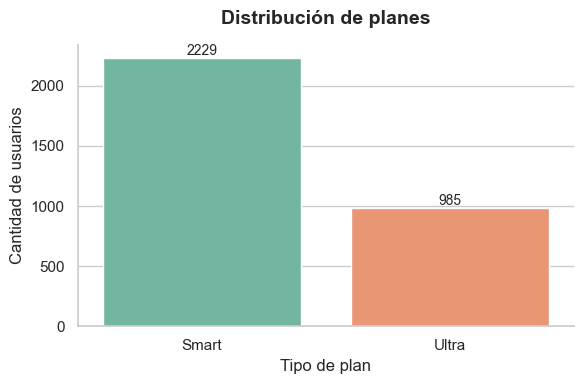

In [75]:
# Prepara los datos para la visualización.
counts = df['is_ultra'].value_counts().reset_index()
counts.columns = ['Plan', 'Cantidad']

# Elegir el estilo
color_palette = sns.color_palette("Set2", n_colors=2)
sns.set_theme(style="whitegrid")

# Graficar la distribución de los planes 'is_ultra'
plt.figure(figsize=(6, 4))
ax = sns.barplot(
    data=counts, 
    x='Plan', 
    y='Cantidad', 
    hue='Plan',              
    palette=color_palette,             
    legend=False,
    errorbar=None
)

# Etiquetas en las barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10)

# Configurando el título y las etiquetas
ax.set_title("Distribución de planes", fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Tipo de plan", fontsize=12)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Smart', 'Ultra'])
ax.set_ylabel("Cantidad de usuarios", fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


El 69% de los usuarios están en el plan Smart, mientras que el 31% están en el plan Ultra. Esto indica que la mayoría de los usuarios prefieren el plan Smart. Es posible considerar un desbalance de clases, sin embargo, realizaremos el estudio para definir el modelo y, si es suficiente para superar el umbral del 75% de exactitud, se dejará esta tarea a futuras mejoras del proyecto. Continuemos revisando la distribución de las demás columnas en los datos.

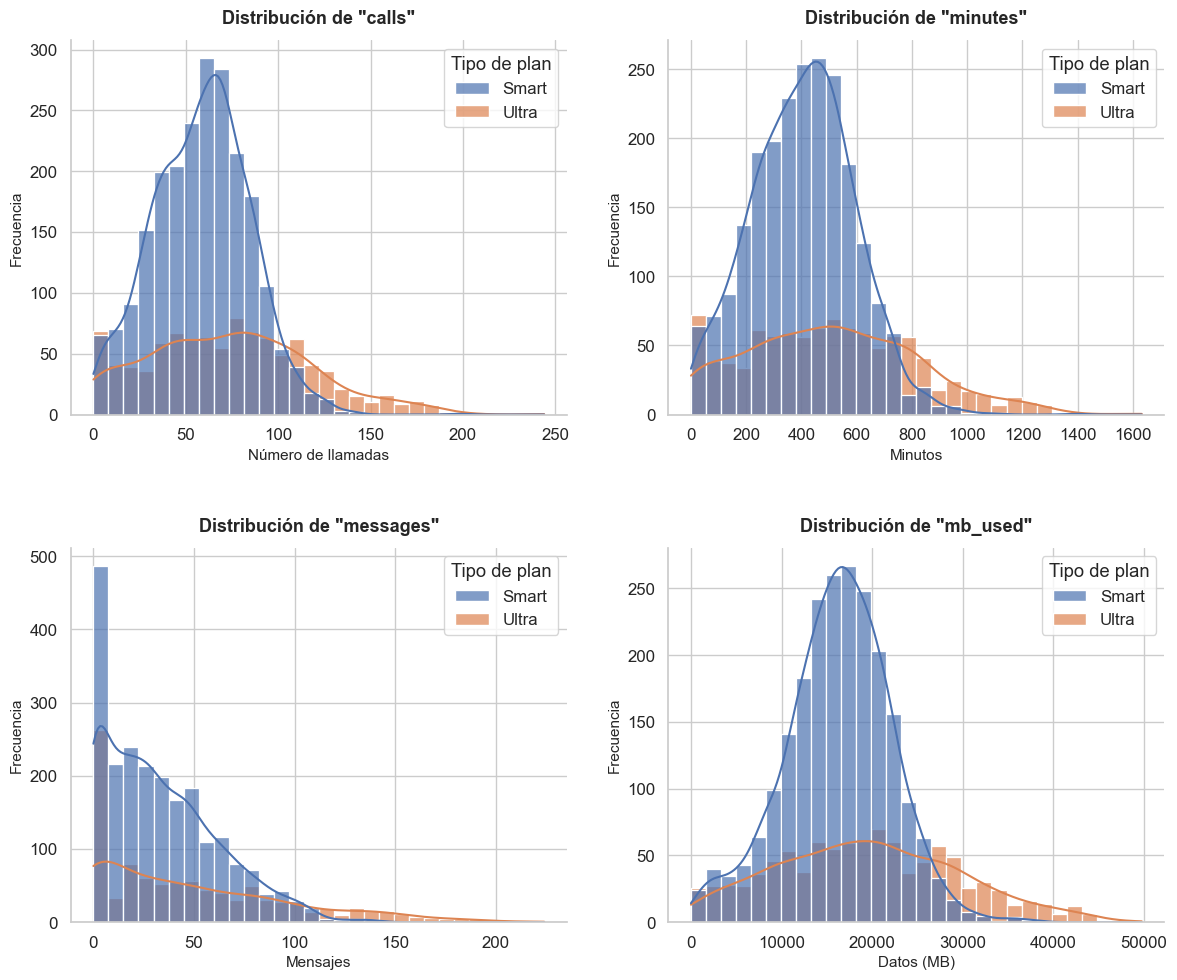

In [ ]:
# Configuración general
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.1)
palette = sns.color_palette('muted', n_colors=4)

# Columnas a graficar
columns = ['calls', 'minutes', 'messages', 'mb_used']
labels = ['Número de llamadas', 'Minutos', 'Mensajes', 'Datos (MB)']
plan_series = df['is_ultra'].map({0: 'Smart', 1: 'Ultra'})
plan_series.name = 'Tipo de plan'

# Crear figura
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Iterar por las columnas y graficar
for i, col in enumerate(columns):
    sns.histplot(data=df, x=col, bins=30, ax=axes[i], kde=True, hue=plan_series, color=palette[i], alpha=0.7, legend=True)

    # Títulos descriptivos
    axes[i].set_title(f'Distribución de "{col}"', fontsize=13, fontweight='bold', pad=12)
    axes[i].set_xlabel(labels[i], fontsize=11)
    axes[i].set_ylabel('Frecuencia', fontsize=11)
    
    # Quitar bordes superiores y derechos
    sns.despine(ax=axes[i])

# Espaciado entre subplots
plt.tight_layout(h_pad=3.0, w_pad=2.0)
plt.show()


Se realizó un análisis exploratorio de los datos para entender mejor la distribución de las variables separadas por tipo de plan. El comportamiento de los usuarios Smart en todas las variables sigue una distribución normal, mientras que los usuarios Ultra tienen una distribución sesgada a la derecha. Esto indica que los usuarios Ultra tienden a utilizar más minutos, mensajes y tráfico de Internet en comparación con los usuarios Smart.

## 3. Segmentación de los datos para el entrenamiento del modelo. <a id="data_segment"></a>

Para entrenar el modelo requeriremos segmentar los datos en tres grupos: datos para el entrenamiento (60% de las observaciones), datos para la validación (20% de las observaciones) y datos para la prueba del modelo (20% de las observaciones).

In [5]:
# Separación del grupo para el entrenamiento.
train_df, valid_df = train_test_split(df, test_size = 0.4, random_state = 12345)

# Separación del grupo para el la validación y las pruebas.
valid_df, test_df = train_test_split(valid_df, test_size = 0.5, random_state = 12345)

In [6]:
# Dataset de entrenamiento.
train_df

,calls,minutes,messages,mb_used,is_ultra
3027,60.0,431.56,26.0,14751.26,0
434,33.0,265.17,59.0,17398.02,0
1226,52.0,341.83,68.0,15462.38,0
1054,42.0,226.18,21.0,13243.48,0
1842,30.0,198.42,0.0,8189.53,0
...,...,...,...,...,...
2817,12.0,86.62,22.0,36628.85,1
546,65.0,458.46,0.0,15214.25,1
382,144.0,906.18,0.0,25002.44,1
2177,38.0,301.27,37.0,28914.24,1


In [7]:
# Dataset de validación.
valid_df

,calls,minutes,messages,mb_used,is_ultra
1386,92.0,536.96,18.0,20193.90,0
3124,40.0,286.57,17.0,17918.75,0
1956,81.0,531.22,56.0,17755.06,0
2286,67.0,460.76,27.0,16626.26,0
3077,22.0,120.09,16.0,9039.57,0
...,...,...,...,...,...
1999,56.0,398.45,4.0,23682.94,0
1023,76.0,601.10,0.0,17104.36,0
748,81.0,525.97,15.0,18878.91,0
1667,10.0,63.03,0.0,2568.00,1


In [8]:
# Dataset de prueba.
test_df

,calls,minutes,messages,mb_used,is_ultra
160,61.0,495.11,8.0,10891.23,0
2498,80.0,555.04,28.0,28083.58,0
1748,87.0,697.23,0.0,8335.70,0
1816,41.0,275.80,9.0,10032.39,0
1077,60.0,428.49,20.0,29389.52,1
...,...,...,...,...,...
2401,55.0,446.06,79.0,26526.28,0
2928,102.0,742.65,58.0,16089.24,1
1985,52.0,349.94,42.0,12150.72,0
357,39.0,221.18,59.0,17865.23,0


## 4. Exploración para elegir el modelo. <a id="model_explore"></a>

Para poder definir el mejor modelo, realizaremos pruebas para 3 tipos de modelos:
- Árbol de decisión.
- Bosque aleatorio.
- Regresión logística.

Para iniciar las exploraciones, seleccionaremos las características y el objetivo para entrenar y validar nuestro modelo.

In [9]:
# Caracteristivas y objetivos del dataframe de entrenamiento.
features_train = train_df.drop('is_ultra', axis=1)
target_train = train_df['is_ultra']

# Caracteristivas y objetivos del dataframe de validación.
features_valid = valid_df.drop('is_ultra', axis=1)
target_valid = valid_df['is_ultra']

# Caracteristivas y objetivos del dataframe de prueba.
features_test = test_df.drop('is_ultra', axis=1)
target_test = test_df['is_ultra']

### 4.1. Exploración del modelo Decision Tree Classifier. <a id="model_decision_tree"></a>

Definiremos una serie de árboles con profundidades de 1 a 10, para evaluar cuál tiene mejores resultados de exactitud en el dataset de validación.

In [10]:
#DecisionTreeClassifier

# Variables de resultados de exactitud.
best_score = 0
best_depth = 0

# Evaluación de profundidad.
for depth in range(1, 11):
    model_dtc = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model_dtc.fit(features_train, target_train)
    score = model_dtc.score(features_valid, target_valid)
    if score > best_score:
        best_score = score
        best_depth = depth
        
# Imprimir el resultado
print("La exactitud del mejor modelo en el conjunto de validación (profundidad = {}): {}".format(best_depth, best_score))

La exactitud del mejor modelo en el conjunto de validación (profundidad = 3): 0.7853810264385692


La conclusión de nuestra evaluación nos muestra que un árbol con profundidad de 3 es la mejor opción para este tipo de modelo, con una exactitud del 78.54%, lo suficiente para cumplir con nuestro umbral del 75%; sin embargo, podríamos observar mejores resultados en las próximas exploraciones.

### 4.2. Exploración del modelo Random Forest Classifier. <a id="model_random_forest"></a>

Para esta clase de modelo variaremos dos hiperparámetros en nuestra exploración: la cantidad de árboles del bosque y la profundidad máxima de estos. Para la primera variable utilizaremos valores de árboles totales 10, 20, 30, 40 y 50, mientras que para la profundidad máxima mantendremos la exploración de 1 a 10 niveles máximos.

In [11]:
#RandomForestClassifier

# Variables de resultados de exactitud.
best_score = 0
best_est = 0
best_depth = 0

# Evaluación de estimadores y profundidad.
for est in range(10, 51, 10):
    for depth in range (1, 11):
        model_rfc = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth= depth)
        model_rfc.fit(features_train, target_train)        
        score = model_rfc.score(features_valid, target_valid)
        
        if score > best_score:
            best_score = score
            best_depth = depth
            best_est = est

# Imprimir el resultado
print("La exactitud del mejor modelo en el conjunto de validación:", best_score, "n_estimators:", best_est, "best_depth:", best_depth)

La exactitud del mejor modelo en el conjunto de validación: 0.8087091757387247 n_estimators: 40 best_depth: 8


Los resultados nos muestran que un modelo con 40 árboles o estimadores cada uno con una profundidad máxima de 8 es la mejor opción. La exactitud que nos arroja es de 80.87%, la más alta hasta el momento.

### 4.3. Exploración del modelo Logistic Regression. <a id="model_logistic_regression"></a>

Finalmente, evaluaremos un modelo de regresión logística.

In [12]:
#LogisticRegression

#Evaluación del modelo.
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)

score = model_lr.score(features_valid, target_valid) 

# Imprimir el resultado
print("La exactitud del modelo de regresión logística en el conjunto de validación:", score)

La exactitud del modelo de regresión logística en el conjunto de validación: 0.7589424572317263


La exactitud de este modelo nos muestra 75.89%, apenas suficiente para superar nuestro umbral del 75% pero siendo la más deficiente de nuestras tres exploraciones.

### 4.4. Resultados y selección del modelo. <a id="model_results"></a>

El modelo de bosque aleatorio mostró el mejor desempeño para el cálculo de la exactitud en las predicciones de nuestros datos de validación (80.87%), por lo que se utilizará este modelo con los valores de 40 estimadores y 8 en la profundidad máxima de los árboles para la predicción de las observaciones de prueba.

## 5. Predicción para los datos de prueba. <a id="model_prediction"></a>

Con nuestro modelo ya seleccionado, ahora utilizaremos un dataset más completo para entrenarlo y esperar que este mejore en sus predicciones, por lo que se usarán los datos de entrenamiento y validación para el nuevo entrenamiento y predicción de los datos de prueba.

In [13]:
# Integración de los datos de entranamiento con los de validación.
train_df_full = pd.concat([train_df, valid_df])

# Seleccion de las caracteristicas y los objetivos para el nuevo entrenamiento.
features_train_full = train_df_full.drop('is_ultra', axis=1)
target_train_full = train_df_full['is_ultra']

In [14]:
#RandomForestClassifier

# Creación del modelo con los hiperparametros descritos en los resultados.
model = RandomForestClassifier(random_state = 12345, n_estimators = 40, max_depth= 8)

# Entrenamiento del modelo con el 80% de los datos.
model.fit(features_train_full, target_train_full)

# Predicciones para los datos de entrenamiento y de prueba.
train_prediction = model.predict(features_train_full)
test_prediction = model.predict(features_test)

# Comparación y resultados.
print("Conjunto de entrenamiento:",accuracy_score(target_train_full, train_prediction))
print("Conjunto de prueba:",accuracy_score(target_test, test_prediction))

Conjunto de entrenamiento: 0.8619214313496694
Conjunto de prueba: 0.7993779160186625


## Conclusiones <a id="end"></a>

Los resultados para nuestro conjunto de prueba muestran una exactitud de 79.94%, algo ligeramente menor al obtenido con nuestro conjunto de validación, aun así demuestra un mejor desempeño que los demás modelos y se encuentra por encima de nuestro umbral de 75%, por lo que aceptaremos esta exactitud para esta solución.

En cuanto a las predicciones con nuestro conjunto de entrenamiento observamos una precisión de 86.19%, lo que significa una diferencia de 6.25 puntos porcentuales, esto nos demuestra que pudiera existir un sobre ajuste muy ligero; sin embargo, no es significativo como para considerar que el modelo no funcionará para nuevas predicciones.

También es importante mencionar que se pueden explorar los resultados del modelo ajustando un poco el ligero desbalance de clases, aunque no asegura una mejora en el mismo.